## MLflow w/ Databricks 

In [1]:
# !pip install --upgrade mlflow 
# !pip install databricks-sdk

In [3]:
import os
import mlflow 
import pandas as pd, numpy as np 
mlflow.__version__

'2.13.0'

## Setting HOST, tracking_uri, experiment

In [8]:
os.environ["DATABRICKS_HOST"] = "https://1729347641531388.8.gcp.databricks.com"
os.getenv("DATABRICKS_HOST")

'https://1729347641531388.8.gcp.databricks.com'

In [9]:
mlflow.set_tracking_uri("databricks")
mlflow.get_tracking_uri()

'databricks'

In [10]:
mlflow.set_experiment("/testing")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/12486346832556', creation_time=1715949611332, experiment_id='12486346832556', last_update_time=1716989823331, lifecycle_stage='active', name='/testing', tags={'mlflow.experiment.sourceName': '/testing',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'chris.marais@satalia.com',
 'mlflow.ownerId': '7068895414970915'}>

## Logging params / metrics 

In [11]:
with mlflow.start_run():
    mlflow.log_param("my_param", 3.14)
    mlflow.log_metric("my_metric", 3.1)

## Logging inputs (wine) 

In [12]:
import pandas as pd 

src = "https://raw.githubusercontent.com/mlflow/mlflow/master/tests/datasets/winequality-white.csv"
df = pd.read_csv(src, delimiter=";")
dataset = mlflow.data.from_pandas(
    df, source=src, name="wine quality - white", targets="quality"
)

/Users/chris.marais/.local/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'https://raw.githubusercontent.com/mlflow/mlflow/master/tests/datasets/winequality-white.csv'. Exception: 
  return _dataset_source_registry.resolve(


In [13]:
dataset._to_mlflow_entity()

/Users/chris.marais/.local/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


<Dataset: digest='2a1e42c4', name='wine quality - white', profile='{"num_rows": 4898, "num_elements": 58776}', schema=('{"mlflow_colspec": [{"type": "double", "name": "fixed acidity", "required": '
 'true}, {"type": "double", "name": "volatile acidity", "required": true}, '
 '{"type": "double", "name": "citric acid", "required": true}, {"type": '
 '"double", "name": "residual sugar", "required": true}, {"type": "double", '
 '"name": "chlorides", "required": true}, {"type": "double", "name": "free '
 'sulfur dioxide", "required": true}, {"type": "double", "name": "total sulfur '
 'dioxide", "required": true}, {"type": "double", "name": "density", '
 '"required": true}, {"type": "double", "name": "pH", "required": true}, '
 '{"type": "double", "name": "sulphates", "required": true}, {"type": '
 '"double", "name": "alcohol", "required": true}, {"type": "long", "name": '
 '"quality", "required": true}]}'), source=('{"url": '
 '"https://raw.githubusercontent.com/mlflow/mlflow/master/tests/d

In [14]:
dataset.name

'wine quality - white'

In [15]:
dataset.targets

'quality'

In [16]:
mlflow.log_input(dataset)

As I hoped, this mlflow dataset object is only storing metadata about the input dataset

In [17]:
import sys
sys.getsizeof(dataset), sys.getsizeof(df)

(56, 470372)

## Logging large inputs 

In [26]:
n, m = 1000,1000
df = pd.DataFrame(np.random.rand(n, m))
ds = mlflow.data.from_pandas(df, name=f"{n}x{m}")
mlflow.log_input(ds)
mlflow.end_run()

In [27]:
from cloudpathlib import CloudPath
gspath = "gs://performancebrain_experiments/tccc/XWPBP-85/india-cocacola-vtr_25p-5.csv"
df = pd.read_csv(CloudPath(gspath), dtype={
    'Media: Campaign: Campaign ID': str,
    'Media: Campaign: Adset ID': str,
    'Media: Campaign: Ad ID': str,
    'Media: Campaign: Creative ID': str
})
df.shape

(8482, 102)

In [65]:
# Assuming df is already defined
elapsed_times = {'n': [], 'm': [], 'time': []}

with mlflow.start_run():
    for n in [100, 500, 2000, 4000]:
        for m in [5, 10, 50, 80]:
            ds = mlflow.data.from_pandas(df.iloc[:n, :m], name=f"{n}x{m}")
            print(n, m)
            start = time.time()
            mlflow.log_input(ds)
            elapsed = time.time() - start
            print(f"Elapsed: {elapsed:0.2f}s")        
            elapsed_times['n'].append(n)
            elapsed_times['m'].append(m)
            elapsed_times['time'].append(elapsed)

100 5
Elapsed: 0.45s
100 10
Elapsed: 0.60s
100 50
Elapsed: 0.72s
100 80
Elapsed: 1.15s
500 5
Elapsed: 1.23s
500 10
Elapsed: 2.09s
500 50
Elapsed: 2.85s
500 80
Elapsed: 5.86s
2000 5
Elapsed: 4.41s
2000 10
Elapsed: 7.98s
2000 50
Elapsed: 11.47s
2000 80
Elapsed: 20.69s
4000 5
Elapsed: 7.86s
4000 10
Elapsed: 15.52s
4000 50
Elapsed: 21.24s
4000 80
Elapsed: 42.53s


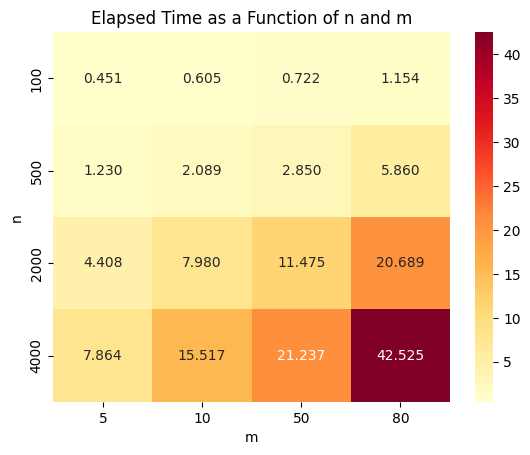

In [66]:
def plot_elapsed(elapsed_times):
    elapsed_df = pd.DataFrame(elapsed_times)
    pivot_table = elapsed_df.pivot_table(values='time', index='n', columns='m')
    
    # Plotting
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlOrRd")
    plt.title('Elapsed Time as a Function of n and m')
    plt.xlabel('m')
    plt.ylabel('n')
    plt.show()
plot_elapsed(elapsed_times)

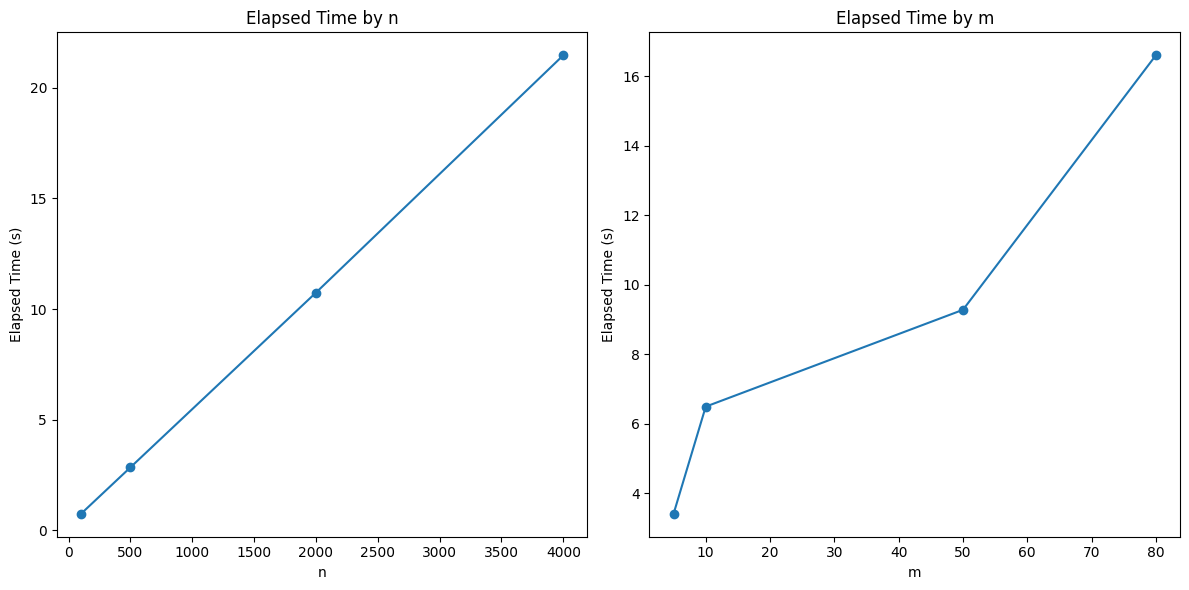

In [43]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Trend by n
elapsed_df.groupby('n')['time'].mean().plot(ax=axs[0], title='Elapsed Time by n', marker='o')
axs[0].set_xlabel('n')
axs[0].set_ylabel('Elapsed Time (s)')

# Trend by m
elapsed_df.groupby('m')['time'].mean().plot(ax=axs[1], title='Elapsed Time by m', marker='o')
axs[1].set_xlabel('m')
axs[1].set_ylabel('Elapsed Time (s)')

plt.tight_layout()
plt.show()

In [53]:
def profile_loginput(df, ns=[100, 500, 2000, 4000], ms=[5, 10, 50, 80]):
    elapsed_times = {'n': [], 'm': [], 'time': []}
    with mlflow.start_run():
        for n in ns:
            for m in ms:
                ds = mlflow.data.from_pandas(df.iloc[:n, :m], name=f"{n}x{m}")
                print(n, m)
                start = time.time()
                mlflow.log_input(ds)
                elapsed = time.time() - start
                print(f"Elapsed: {elapsed:0.2f}s")        
                elapsed_times['n'].append(n)
                elapsed_times['m'].append(m)
                elapsed_times['time'].append(elapsed)
    return elapsed_times

In [57]:
elapsed_rand = profile_loginput(
    pd.DataFrame(np.random.rand(1000,1000)),
    ns = [100, 500, 1000],
    ms = [100, 500, 1000]
)

100 100
Elapsed: 0.20s
100 500
Elapsed: 0.21s
100 1000
Elapsed: 0.24s
500 100
Elapsed: 0.18s
500 500
Elapsed: 0.27s
500 1000
Elapsed: 0.53s
1000 100
Elapsed: 0.21s
1000 500
Elapsed: 0.42s
1000 1000
Elapsed: 0.56s


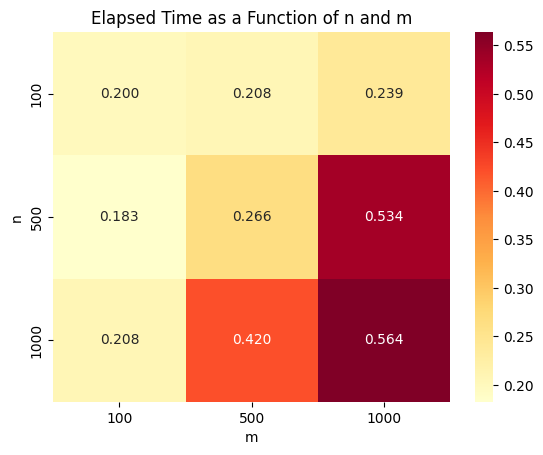

In [64]:
plot_elapsed(elapsed_rand)